In [1]:
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import random
import matplotlib.patches as mpatches
%matplotlib inline  

#### Late fusion approach between organ_1st and organ_2nd

In [5]:
organ_1st = 'branch'
organ_2nd = 'entire'
top_k = 6 # top k scores that you want to know
nb_class = 50
flag_preprocess = False

#### Preprocess for coding convenience

In [6]:
'''
example:
Change from:

|organ 1              | organ 2               | organ 1 score     | organ 2 score    |
|data/branch/123.jpg  | data/entire/256.jpg   | 0.6               | 0.4              |

to:

|organ 1              | organ 2               | organ 1 score     | organ 2 score    |
|xxxxxxxxxxxxx        | xxxxxxxxxxxxx         | 0.6               | 0.4              |
'''
if (flag_preprocess):
    f_1st = open('./fusion_data/' + 'single_organ_score/test_result_50_' +
                 organ_1st + '_pretrained.txt', 'r')
    f_2nd = open('./fusion_data/' + 'single_organ_score/test_result_50_' +
                 organ_2nd + '_pretrained.txt', 'r')
    fo_1st = open('./fusion_data/' + organ_1st + '_' + organ_2nd +
                  '_50_species/test_result_50_' + organ_1st + '_pretrained.txt', 'w')
    fo_2nd = open('./fusion_data/' + organ_1st + '_' + organ_2nd +
                  '_50_species/test_result_50_' + organ_2nd + '_pretrained.txt', 'w')

    count_line = 0
    for line_1st in f_1st:
        fo_1st.write(str(count_line/nb_class) + ' ' + line_1st.split(' ')[-3] +
                      ' ' + line_1st.split(' ')[-2] +  ' ' + line_1st.split(' ')[-1])
        count_line = count_line + 1
    count_line = 0    
    for line_2nd in f_2nd:
        fo_2nd.write(str(count_line/nb_class) + ' ' + line_2nd.split(' ')[-3] +
                      ' ' + line_2nd.split(' ')[-2] + ' ' + line_2nd.split(' ')[-1])
        count_line = count_line + 1

    f_1st.close()
    f_2nd.close()
    fo_1st.close()
    fo_2nd.close()

    f_1st = open('./fusion_data/' + 'single_organ_score/svm_result_50_' +
                 organ_1st + '_pretrained.txt', 'r')
    f_2nd = open('./fusion_data/' + 'single_organ_score/svm_result_50_' +
                 organ_2nd + '_pretrained.txt', 'r')
    fo_1st = open('./fusion_data/' + organ_1st + '_' + organ_2nd + '_50_species/svm_result_50_' +
                  organ_1st + '_pretrained.txt', 'w')
    fo_2nd = open('./fusion_data/' + organ_1st + '_' + organ_2nd + '_50_species/svm_result_50_' +
                  organ_2nd + '_pretrained.txt', 'w')

    count_line = 0   
    for line_1st in f_1st:
        fo_1st.write(str(count_line/nb_class) + ' ' + line_1st.split(' ')[-3] +
                      ' ' + line_1st.split(' ')[-2] +  ' ' + line_1st.split(' ')[-1])
        count_line = count_line + 1
    count_line = 0    
    for line_2nd in f_2nd:
        fo_2nd.write(str(count_line/nb_class) + ' ' + line_2nd.split(' ')[-3] +
                      ' ' + line_2nd.split(' ')[-2] + ' ' + line_2nd.split(' ')[-1])
        count_line = count_line + 1

    f_1st.close()
    f_2nd.close()
    fo_1st.close()
    fo_2nd.close()

#### Using Sum, Product, Max rule

In [34]:
'''
- sum rule: (score of first organ + score of second organ)
- product rule: (score of first organ * score of second organ)
- max rule: max(score of first organ , score of second organ)
'''
nb_class = 50

f_1st = open('./fusion_data/' 'single_organ_score/test_result_50_' +
             organ_1st + '_pretrained.txt', 'r')
f_2nd = open('./fusion_data/' 'single_organ_score/test_result_50_' +
             organ_2nd + '_pretrained.txt', 'r')

score_1st = list()
score_2nd = list()
labels = list()

for line in f_1st:
    score_1st.append(float(line.split(' ')[-1]))
    labels.append(int(line.split(' ')[-3]))
    
for line in f_2nd:
    score_2nd.append(float(line.split(' ')[-1]))
    
st = list()
nd = list()
max_fu = list()
sum_fu = list()
prod_fu = list()

max_fusion =  np.maximum(np.array(score_1st) , np.array(score_2nd))
sum_fusion =  np.array(score_1st) + np.array(score_2nd)
prod_fusion =  np.array(score_1st) * np.array(score_2nd)

for k in range(1, top_k):
    count_true_max = 0
    count_true_sum = 0
    count_true_prod = 0
    count_true_1st = 0
    count_true_2nd = 0
    
    for i in range(len(score_1st)/nb_class):
        if labels[i * nb_class] in np.argsort(max_fusion[i * nb_class : (i + 1) * nb_class])[-k:]:
            count_true_max = count_true_max + 1
        
        if labels[i * nb_class] in np.argsort(sum_fusion[i * nb_class : (i + 1) * nb_class])[-k:]:
            count_true_sum = count_true_sum + 1
            
        if labels[i * nb_class] in np.argsort(prod_fusion[i * nb_class : (i + 1) * nb_class])[-k:]:
            count_true_prod = count_true_prod + 1
            
        if labels[i * nb_class] in np.argsort(score_1st[i * nb_class : (i + 1) * nb_class])[-k:]:
            count_true_1st = count_true_1st + 1

        if labels[i * nb_class] in np.argsort(score_2nd[i * nb_class : (i + 1) * nb_class])[-k:]:
            count_true_2nd = count_true_2nd + 1

    max_fu.append(float(count_true_max) * nb_class/len(score_1st))
    sum_fu.append(float(count_true_sum) * nb_class/len(score_1st))
    prod_fu.append(float(count_true_prod) * nb_class/len(score_1st))
    st.append(float(count_true_1st) * nb_class/len(score_1st))
    nd.append(float(count_true_2nd) * nb_class/len(score_1st))

f_1st.close()
f_2nd.close()

#### Using  classification based SVM

In [35]:
svm_fu = list()
svm = SVC(kernel = 'poly', degree = 3, probability=True)

ret_1st = defaultdict(list)
ret_2nd = defaultdict(list)
labels = list()
points = list()
svm_img_labels = dict()

f_1st = open('./fusion_data/' + organ_1st + '_' + organ_2nd +
             '_50_species/svm_result_50_' + organ_1st + '_pretrained.txt', 'r')
for line in f_1st:
    component = line.split(' ')
    if int(component[2]) % nb_class == 0:
        svm_img_labels[component[0].split('/')[-1]] = int(component[1])
    ret_1st[component[0].split('/')[-1]].append(float(component[3]))
f_1st.close()
f_2nd = open('./fusion_data/' + organ_1st + '_' + organ_2nd +
             '_50_species/svm_result_50_' + organ_2nd + '_pretrained.txt', 'r')
for line in f_2nd:
    component = line.split(' ')
    ret_2nd[component[0].split('/')[-1]].append(float(component[3]))
f_2nd.close()

# Generate negative points
for key in ret_1st.keys():
    points.append([ret_1st[key][svm_img_labels[key]], ret_2nd[key][svm_img_labels[key]]])
    labels.append(1)
    for index in range(50):
        if (index != svm_img_labels[key]):
            points.append([ret_1st[key][index], ret_2nd[key][index]])
            labels.append(0)

svm.fit(points, labels)
print(labels.count(0))
print(labels.count(1))

ret_1st_test = defaultdict(list)
ret_2nd_test = defaultdict(list)
test_img_labels = dict()

f_1st_test = open('./fusion_data/' + organ_1st + '_' + organ_2nd +
                  '_50_species/test_result_50_' + organ_1st + '_pretrained.txt', 'r')
for line in f_1st_test:
    component = line.split(' ')
    if int(component[2]) % nb_class == 0:
        test_img_labels[component[0].split('/')[-1]] = int(component[1])
    ret_1st_test[component[0].split('/')[-1]].append(float(component[3]))
f_1st_test.close()

f_2nd_test = open('./fusion_data/' + organ_1st + '_' + organ_2nd +
                  '_50_species/test_result_50_' + organ_2nd + '_pretrained.txt', 'r')
for line in f_2nd_test:
    component = line.split(' ')
    ret_2nd_test[component[0].split('/')[-1]].append(float(component[3]))
f_2nd_test.close()

# Predict
for k in range(1, top_k):
    count_true = 0
    tot_count = 0
    for key in ret_1st_test.keys():
        pos_list = list()
        neg_list = list()
        position = 0
        for x, y in zip(ret_1st_test[key], ret_2nd_test[key]):
            if svm.predict([[x, y]])[0] == 1:
                pos_list.append([x, y, position])
            else:
                neg_list.append([x, y, position])
            position = position + 1
        
        tot_count = tot_count + 1
        if (pos_list):
            pos_list.sort(key = lambda x: x[0] * x[1])
            if test_img_labels[key] in np.asarray(pos_list[-k:])[:, 2]:
                count_true = count_true + 1               
        else:
            neg_list.sort(key = lambda x:  x[0] * x[1])
            if test_img_labels[key] in np.asarray(neg_list[-k:])[:, 2]:
                count_true = count_true + 1
    svm_fu.append(float(count_true)/(tot_count))

print('svm base: ' + str(svm_fu))

7350
1500
svm base: [0.538, 0.588, 0.612, 0.62, 0.626]


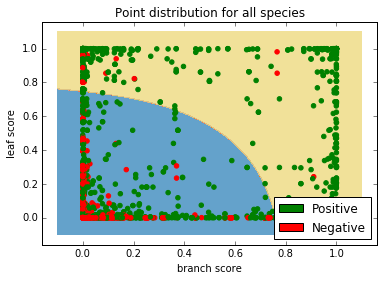

In [148]:
# Plot positive and negative points distribution
fig, ax = plt.subplots()
h = 0.001
x_min, x_max = -0.1, 1.1
y_min, y_max = -0.1, 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = 'SVC with polynomial (degree 4) kernel'

Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)


colors = color= ['red' if l == 0 else 'green' for l in labels]
plt.scatter(np.asarray(points)[:, 0], np.asarray(points)[:, 1], color = colors)

classes = ['Positive','Negative']
class_colours = ['green','red']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=4)
plt.xlabel('branch score')
plt.ylabel('leaf score')
plt.title('Point distribution for all species')
fig.savefig('all.eps', format='eps', dpi = 100)
plt.show()

####  Hybrid Model using Product rule and SVM classification probability

In [38]:
rh_fu = list()
svm = list()
for i in range(nb_class):
    svm.append(SVC(kernel = 'poly', degree = 3, probability=True))

ret_1st = defaultdict(list)
ret_2nd = defaultdict(list)
labels = defaultdict(list)
points = defaultdict(list)
svm_img_labels = dict()

f_1st = open('./fusion_data/' + organ_1st + '_' + organ_2nd + '_50_species/svm_result_50_' +
             organ_1st + '_pretrained.txt', 'r')
for line in f_1st:
    component = line.split(' ')
    if int(component[2]) % nb_class == 0:
        svm_img_labels[component[0].split('/')[-1]] = int(component[1])
    ret_1st[component[0].split('/')[-1]].append(float(component[3]))
f_1st.close()
f_2nd = open('./fusion_data/' + organ_1st + '_' + organ_2nd + '_50_species/svm_result_50_' +
             organ_2nd + '_pretrained.txt', 'r')
for line in f_2nd:
    component = line.split(' ')
    ret_2nd[component[0].split('/')[-1]].append(float(component[3]))
f_2nd.close()

rand_neg_point = random.randint(1, 10000) 

# Generate negative points
for key in ret_1st.keys():
    points[svm_img_labels[key]].append([ret_1st[key][svm_img_labels[key]], ret_2nd[key][svm_img_labels[key]]])
    labels[svm_img_labels[key]].append(1)
    for i in range(10):
        rand_neg_point = random.randint(1, 10000) 
        index = rand_neg_point % nb_class
        if (index != svm_img_labels[key]):
            if labels[index].count(0) > 10 * labels[index].count(1):
                continue
            points[index].append([ret_1st[key][index], ret_2nd[key][index]])
            labels[index].append(0)

for i in range(nb_class):
    svm[i].fit(points[i], labels[i])

ret_1st_test = defaultdict(list)
ret_2nd_test = defaultdict(list)
test_img_labels = dict()

f_1st_test = open('./fusion_data/' + organ_1st + '_' + organ_2nd + '_50_species/test_result_50_' +
                  organ_1st + '_pretrained.txt', 'r')
for line in f_1st_test:
    component = line.split(' ')
    if int(component[2]) % nb_class == 0:
        test_img_labels[component[0].split('/')[-1]] = int(component[1])
    ret_1st_test[component[0].split('/')[-1]].append(float(component[3]))
f_1st_test.close()

f_2nd_test = open('./fusion_data/' + organ_1st + '_' + organ_2nd + '_50_species/test_result_50_' +
                  organ_2nd + '_pretrained.txt', 'r')
for line in f_2nd_test:
    component = line.split(' ')
    ret_2nd_test[component[0].split('/')[-1]].append(float(component[3]))
f_2nd_test.close()

# Predict
for k in range(1, top_k):
    count_true = 0
    tot_count = 0
    for key in ret_1st_test.keys():
        pos_list = list()
        neg_list = list()
        position = 0
        for x, y in zip(ret_1st_test[key], ret_2nd_test[key]):
            if (svm[position].predict_proba([[x, y]])[0][1] > 0):
                pos_list.append([x, y, svm[position].predict_proba([[x, y]])[0][1], position])
            else:
                neg_list.append([x, y, svm[position].predict_proba([[x, y]])[0][1], position])
            position = position + 1
        
        tot_count = tot_count + 1
        if (pos_list):
            pos_list.sort(key = lambda x: x[0] * x[1] * x[2])
            if test_img_labels[key] in np.asarray(pos_list[-k:])[:, 3]:
                count_true = count_true + 1               
        else:
            print('Negative point')
            neg_list.sort(key = lambda x: (x[0] * x[1]))
            if (neg_list[-1][3] == test_img_labels[key]):
                count_true = count_true + 1
                print('Bing go!')
    rh_fu.append(float(count_true)/(tot_count))

print(organ_1st + ': ' + str(st))
print(organ_2nd + ': ' + str(nd))
print('max rule: ' + str(max_fu))
print('sum rule: ' + str(sum_fu))
print('prod rule: ' + str(prod_fu))
print('svm base: ' + str(svm_fu))
print('rh rule: ' + str(rh_fu))

output = open('./fusion_data/' + organ_1st + '_' + organ_2nd + '_top_' + str(top_k) + '_scores.txt', 'w')
output.write(organ_1st + ': ' + str(st) + '\n')
output.write(organ_2nd + ': ' + str(nd) + '\n')
output.write('max rule: ' + str(max_fu) + '\n')
output.write('sum rule: ' + str(sum_fu) + '\n')
output.write('prod rule: ' + str(prod_fu) + '\n')
output.write('svm based: ' + str(svm_fu) + '\n')
output.write('rh rule: ' + str(rh_fu))
output.close()

branch: [0.432, 0.532, 0.592, 0.638, 0.704]
entire: [0.324, 0.442, 0.516, 0.578, 0.64]
max rule: [0.516, 0.616, 0.682, 0.746, 0.768]
sum rule: [0.522, 0.62, 0.694, 0.75, 0.776]
prod rule: [0.58, 0.716, 0.77, 0.796, 0.836]
svm base: [0.538, 0.588, 0.612, 0.62, 0.626]
rh rule: [0.586, 0.716, 0.77, 0.806, 0.84]


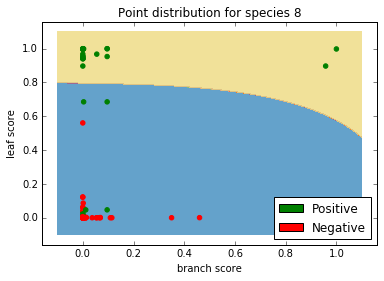

In [23]:
# Plot positve and negative points distribution for each species
fig, ax = plt.subplots()
id = 8
h = 0.001
x_min, x_max = -0.1, 1.1
y_min, y_max = -0.1, 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svm[id].predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)


colors = color= ['red' if l == 0 else 'green' for l in labels[id]]
plt.scatter(np.asarray(points[id])[:, 0], np.asarray(points[id])[:, 1], color = colors)

classes = ['Positive','Negative']
class_colours = ['green','red']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=4)
plt.xlabel('branch score')
plt.ylabel('leaf score')
plt.title('Point distribution for species %d' %id)
fig.savefig('one.eps', format='eps', dpi=1000)
plt.show()